In [1]:
import json
import copy
import numpy as np
import pandas as pd

import sys
sys.path.append('../../GillesPy2/')
import gillespy2
print(gillespy2.__version__)
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS
from gillespy2 import SSACSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

1.6.7


## Read in observed data

In [2]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('../month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

# Devils DFTD 2-Stage Infection with Vaccination

In [3]:
dates = []
year = 1985
while len(dates) < 1001:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

In [4]:
class DevilsDFTD2StageInfectionWithVaccination(Model):
    def __init__(self, values=None):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection with Vaccination")
        self.volume = 1

        # Parameters (Pre-Vaccination)
        birth_rate = Parameter(name="birth_rate", expression="0.055")
        death_rate_diseased = Parameter(name="death_rate_diseased", expression="0.048")
        death_rate_infected = Parameter(name="death_rate_infected", expression="0.03")
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression="0.006")
        death_rate_over_population = Parameter(name="death_rate_over_population", expression="2.3e-07")
        death_rate_susceptible = Parameter(name="death_rate_susceptible", expression="0.02335")
        incubation = Parameter(name="incubation", expression="22.6")
        infection_rate_diseased = Parameter(name="infection_rate_diseased", expression="3e-05")
        infection_rate_infected = Parameter(name="infection_rate_infected", expression="2e-05")
        maturity_rate = Parameter(name="maturity_rate", expression="0.04267")
        progression = Parameter(name="progression", expression="12")
        DFTD_introduction = Parameter(name="DFTD_introduction", expression="40")
        self.add_parameter([
            birth_rate, death_rate_diseased, death_rate_infected, death_rate_juvenile, death_rate_over_population,
            death_rate_susceptible, incubation, infection_rate_diseased, infection_rate_infected,
            maturity_rate, progression, DFTD_introduction
        ])
        
        # Parameters (Vaccination)
        vaccinated_infection_rate = Parameter(
            name="vaccinated_infection_rate", expression="0.25"
        )
        vaccination_proportion = Parameter(name="vaccination_proportion", expression="0.6")
        vaccine_frequency = Parameter(name="vaccine_frequency", expression="3")
        vaccine_time = Parameter(name="vaccine_time", expression="0")
        program_length = Parameter(name="program_length", expression="3")
        self.add_parameter([
            vaccinated_infection_rate, vaccination_proportion, vaccine_frequency, vaccine_time, program_length
        ])
        
        # Variables (Pre-Vaccination)
        init_Devils_pop = round(devil_pop[0])
        init_J_pop = round(devil_pop[0] * 0.467)
        init_S_pop = round(devil_pop[0] - init_J_pop)
        
        Devils = Species(name="Devils", initial_value=init_Devils_pop, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Juvenile = Species(name="Juvenile", initial_value=init_S_pop, mode="discrete")
        Susceptible = Species(name="Susceptible", initial_value=init_J_pop, mode="discrete")
        self.add_species([Devils, Diseased, Exposed, Infected, Juvenile, Susceptible])
        
        # Variables (Vaccination)
        Vaccinated = Species(name="Vaccinated", initial_value=0, mode="discrete")
        self.add_species(Vaccinated)
        
        # Reactions (Pre-Vaccination)
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected + Vaccinated)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased"
        )
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * Susceptible * Infected"
        )
        self.add_reaction([
            Birth, Mature, Death_Diseased, Death_Diseased2, Death_Exposed, Death_Exposed2, Death_Infected,
            Death_Infected2, Death_Juvenile, Death_Juvenile2, Death_Susceptible, Death_Susceptible2,
            DFTD_Stage1, DFTD_Stage2, TransmissionD, TransmissionI
        ])
        
        # Reactions (Vaccination)
        Vaccine_Failure_I = Reaction(name="Vaccine_Failure_I",
            reactants={'Vaccinated': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * vaccinated_infection_rate * Vaccinated * Infected / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Vaccine_Failure_D = Reaction(name="Vaccine_Failure_D",
            reactants={'Vaccinated': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * vaccinated_infection_rate * Vaccinated * Diseased / \
                                            (Susceptible + Exposed + Infected + Vaccinated + Diseased + Juvenile)"
        )
        Death_Vaccinated = Reaction(name="Death_Vaccinated",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_susceptible * Vaccinated"
        )
        Death_Vaccinated2 = Reaction(name="Death_Vaccinated2",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_over_population * Vaccinated * (Devils - 1)"
        )
        self.add_reaction([Vaccine_Failure_I, Vaccine_Failure_D, Death_Vaccinated, Death_Vaccinated2])
        
        # Event Triggers
        # DFTD_Introduction_trig = EventTrigger(
        #     expression="t >= DFTD_introduction",initial_value=False, persistent=False
        # )
        # Vaccination_trig = EventTrigger(
        #     expression="t >= 444 + vaccine_time and program_length > 0", initial_value=False, persistent=True
        # )

        # Event Assignments
        # DFTD_Introduction_assign_1 = EventAssignment(variable="Infected", expression="1")
        # DFTD_Introduction_assign_2 = EventAssignment(variable="Susceptible", expression="Susceptible - 1")
        # Vaccination_assign_1 = EventAssignment(
        #     variable="vaccine_time", expression="vaccine_time + 12 / vaccine_frequency"
        # )
        # Vaccination_assign_2 = EventAssignment(
        #     variable="program_length", expression="program_length - (12 / vaccine_frequency) / 12"
        # )
        # Vaccination_assign_3 = EventAssignment(
        #     variable="Vaccinated", expression="Vaccinated + (Susceptible * vaccination_proportion)"
        # )
        # Vaccination_assign_4 = EventAssignment(
        #     variable="Susceptible", expression="Susceptible * (1 - vaccination_proportion)"
        # )

        # Events
        # DFTD_Introduction = Event(
        #     name="DFTD_Introduction", trigger=DFTD_Introduction_trig, use_values_from_trigger_time=False,
        #     assignments=[DFTD_Introduction_assign_1, DFTD_Introduction_assign_2], delay=None, priority="0"
        # )
        # Vaccination_Program = Event(
        #     name="Vaccination", trigger=Vaccination_trig, delay=None, priority="0", use_values_from_trigger_time=True,
        #     assignments=[Vaccination_assign_1, Vaccination_assign_2, Vaccination_assign_3, Vaccination_assign_4]
        # )
        # self.add_event(DFTD_Introduction)
        # self.add_event(Vaccination_Program)

        # Timespan
        self.timespan(np.arange(0, 1001, 1))

In [5]:
model = DevilsDFTD2StageInfectionWithVaccination()

In [16]:
model.to_json()

'{\n    "_generate_translation_table": true,\n    "_hash_private_vars": false,\n    "_listOfAssignmentRules": {},\n    "_listOfEvents": {},\n    "_listOfFunctionDefinitions": {},\n    "_listOfParameters": {\n        "DFTD_introduction": "P0",\n        "birth_rate": "P1",\n        "death_rate_diseased": "P2",\n        "death_rate_infected": "P3",\n        "death_rate_juvenile": "P4",\n        "death_rate_over_population": "P5",\n        "death_rate_susceptible": "P6",\n        "incubation": "P7",\n        "infection_rate_diseased": "P8",\n        "infection_rate_infected": "P9",\n        "maturity_rate": "P10",\n        "program_length": "P12",\n        "progression": "P11",\n        "vaccinated_infection_rate": "P13",\n        "vaccination_proportion": "P14",\n        "vaccine_frequency": "P15",\n        "vaccine_time": "P16"\n    },\n    "_listOfRateRules": {},\n    "_listOfReactions": {\n        "Birth": {\n            "_type": "gillespy2.core.reaction.Reaction",\n            "annota

# Simulation Parameters

In [6]:
def configure_simulation():
    solver = SSACSolver(model=model, variable=True)
    kwargs = {
        "solver": solver,
        "number_of_trajectories": 1,
    }
    return kwargs

In [7]:
def run(model, kwargs):
    run_args = copy.deepcopy(kwargs)
    if "variables" not in run_args:
        orig_vars = {}
        run_args['variables'] = {}
    else:
        orig_vars = copy.deepcopy(run_args['variables'])
    
    # Run Pre-infection Period
    model.resolve_parameters()
    if 'DFTD_introduction' in run_args['variables']:
        dfdt_intro = run_args['variables']['DFTD_introduction']
    else:
        dfdt_intro = model.listOfParameters['DFTD_introduction'].value
    res1 = model.run(**run_args, t=dfdt_intro - 1)

    # Configure Infection Period
    run_args['variables']['Infected'] = "1"
    run_args['variables']['Susceptible'] = f"{int(res1[0]['Susceptible'][-1] - 1)}"
    if 'vaccine_time' in run_args['variables']:
        vaccine_time = run_args['variables']['vaccine_time']
    else:
        vaccine_time = model.listOfParameters['vaccine_time'].value

    # Run Infection Period
    prog_start = 444 + vaccine_time
    result = model.run(resume=res1, t=prog_start, **run_args)
    while result['Infected'][-1] <= 0:
        result = model.run(resume=res1, t=prog_start - 1, **run_args)

    # Configure Vaccination Period
    if 'vaccine_frequency' in run_args['variables']:
        vaccine_frequency = run_args['variables']['vaccine_frequency']
    else:
        vaccine_frequency = model.listOfParameters['vaccine_frequency'].value
    if 'program_length' in run_args['variables']:
        program_length = run_args['variables']['program_length']
    else:
        program_length = model.listOfParameters['program_length'].value

    # Run Vaccination Period
    def __run_vaccine_period(model, resume, t, args):
        if 'vaccination_proportion' in args['variables']:
            vaccination_proportion = args['variables']['vaccination_proportion']
        else:
            vaccination_proportion = model.listOfParameters['vaccination_proportion'].value
        sus_pop = resume[0]['Susceptible'][-1]
        vacc_pop = resume[0]['Vaccinated'][-1]
        new_vacc_pop = int(sus_pop * vaccination_proportion)
        args['variables']['Vaccinated'] = int(vacc_pop + new_vacc_pop)
        args['variables']['Susceptible'] = int(sus_pop - new_vacc_pop)
        return model.run(resume=resume, t=t, **args)
    
    prog_inter = 12 / vaccine_frequency
    prog_end = prog_start + program_length * 12
    t = prog_start
    while t < prog_end:
        t += prog_inter
        run_args['variables'] = orig_vars
        result = __run_vaccine_period(model, result, t - 1, run_args)
        if "Vaccinated" in orig_vars:
            del orig_vars['Vaccinated']
            del orig_vars['Susceptible']

    run_args['variables'] = orig_vars
    return model.run(resume=result, **run_args)

In [8]:
config_settings = configure_simulation()
results = run(model, config_settings)

Model		: <class '__main__.DevilsDFTD2StageInfectionWithVaccination'>
Solver.Model	: <class '__main__.DevilsDFTD2StageInfectionWithVaccination'>
Model		: ff96043ba4039328c7dc0772183cc823
Solver.Model	: 33ccd9f46122dfdcfd50eca1eabde011
<===Species===>
<===Parameters===>
<===Reactions===>


# Visualization

In [9]:
def plot(results, start=0, alpha=0.3):
    carry_cap = int(max(devil_pop)*1.16)
    dftd_start = int(results.model.listOfParameters['DFTD_introduction'].value)
    vaccine_start = int(444 + int(results.model.listOfParameters['vaccine_time'].value))
    spec_list = [results['Juvenile'], results['Susceptible'], results['Exposed'],
                 results['Infected'], results['Diseased'], results['Vaccinated']]
    total_devils = np.add.reduce(spec_list)
    x = results['time'][start:]
    text_offset = (results['time'].size - start) / 601
    
    
    plt.figure(figsize=[15, 8])
    plt.title("Tasmanian Devil Population with DFTD: Vaccination Program", fontsize=18)
    plt.xlabel(f"Time (months) since {dates[start]}", fontsize=14)
    plt.ylabel("Population of Tasmanian Devils", fontsize=14)
    plt.plot(x, total_devils[start:], color='blue', label='Total Devils')
    plt.plot(x, results['Juvenile'][start:], color='purple', alpha=alpha, label='Juvenile')
    plt.plot(x, results['Susceptible'][start:], color='green', alpha=alpha, label='Susceptible')
    plt.plot(x, results['Exposed'][start:], color='magenta', alpha=alpha, label='Exposed')
    plt.plot(x, results['Infected'][start:], color='red', alpha=alpha, label='Infected')
    plt.plot(x, results['Diseased'][start:], color='brown', alpha=alpha, label='Diseased')
    plt.plot(x, results['Vaccinated'][start:], color='cyan', alpha=alpha, label='Vaccinated')
    plt.ylim([-3000, carry_cap])
    if start <= dftd_start:
        plt.plot([dftd_start, dftd_start], [-3000, carry_cap], '--r', alpha=0.3)
        plt.text(dftd_start-10*text_offset, 45000, "DFTD Introduced", rotation="vertical", color="red", fontsize=12)
        plt.text(dftd_start+3*text_offset, 48000, dates[dftd_start], rotation="vertical", color="red", fontsize=12)
    plt.plot([vaccine_start, vaccine_start], [-3000, carry_cap], '--r', alpha=0.3)
    plt.text(vaccine_start-10*text_offset, 30000,
             "Start Vaccination Program", rotation="vertical", color="red", fontsize=12)
    plt.text(vaccine_start+3*text_offset, 37000,
             dates[vaccine_start], rotation="vertical", color="red", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation="vertical", va="center")
    plt.legend(loc='best', fontsize=12)

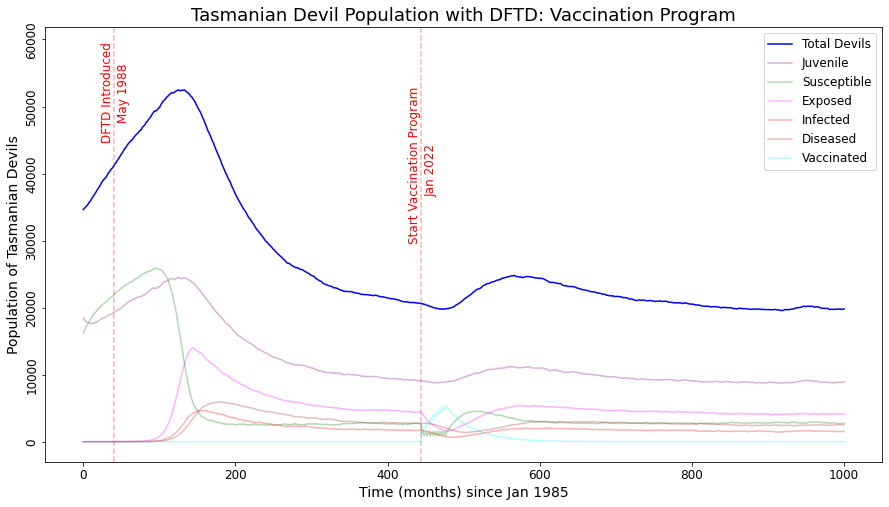

In [10]:
plot(results)

In [11]:
class ParameterSweep():
    def __init__(self, model, settings, params):
        self.model = model
        self.settings = settings
        self.params = params
        self.results = {}


    def __get_result_key(self, variables):
        elements = []
        for name, value in variables.items():
            elements.append(f"{name}:{value}")
        return ",".join(elements)


    def __run(self, index, variables, verbose):
        if index < len(self.params):
            param = self.params[index]
            index += 1
            for val in param['range']:
                variables[param['parameter']] = val
                self.__run(index=index, variables=variables, verbose=verbose)
        else:
            tmp_mdl = self.__setup_model(variables=variables)
            result_key = self.__get_result_key(variables=variables)
            if verbose:
                message = f'running: {result_key.replace(":", "=").replace(",", ", ")}'
                print(message)
            tmp_result = run(tmp_mdl, self.settings)
            self.results[result_key] = tmp_result


    def __setup_model(self, variables):
        self.settings['variables'] = variables
        return self.model

    def run(self, verbose=False):
        '''
        Run a parameter scan job

        Attributes
        ----------
        '''
        index = 0
        variables = {}
        self.__run(index=index, variables=variables, verbose=verbose)


In [12]:
params = [{"parameter": "program_length", "range": [3, 6, 9, 12, 15]}]
job = ParameterSweep(model=model, settings=config_settings, params=params)

In [13]:
%time job.run()

CPU times: user 983 ms, sys: 387 ms, total: 1.37 s
Wall time: 12.6 s


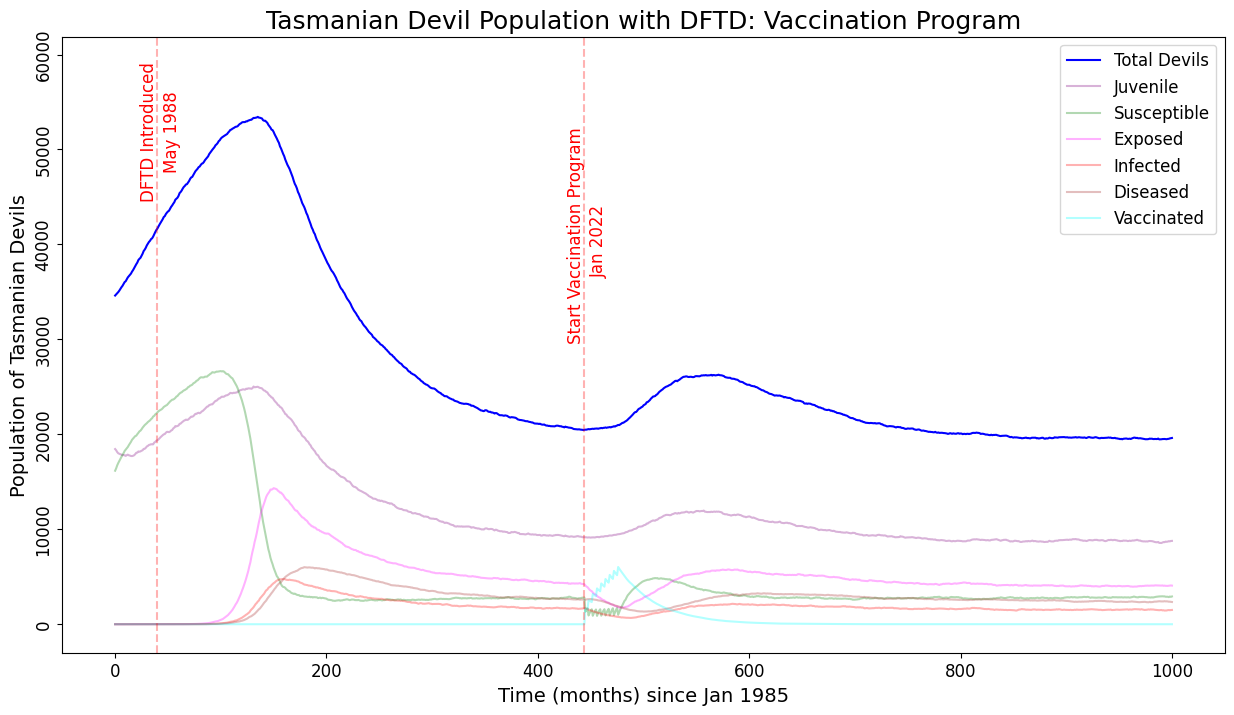

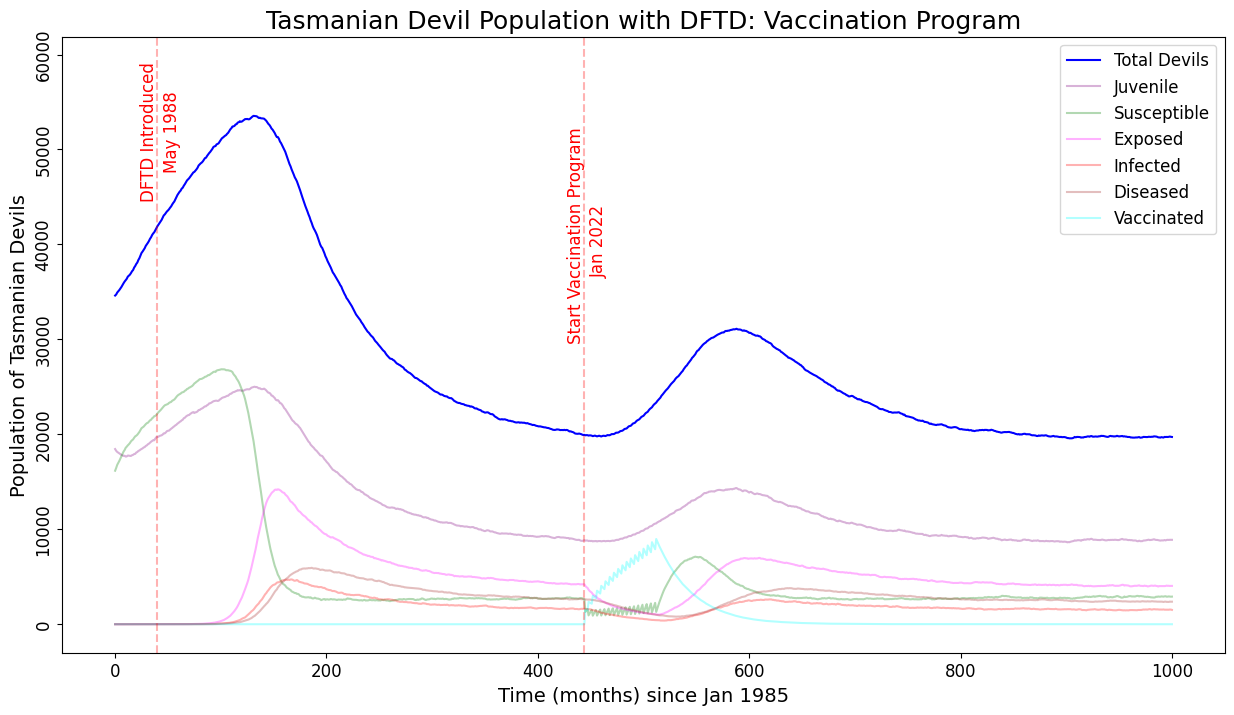

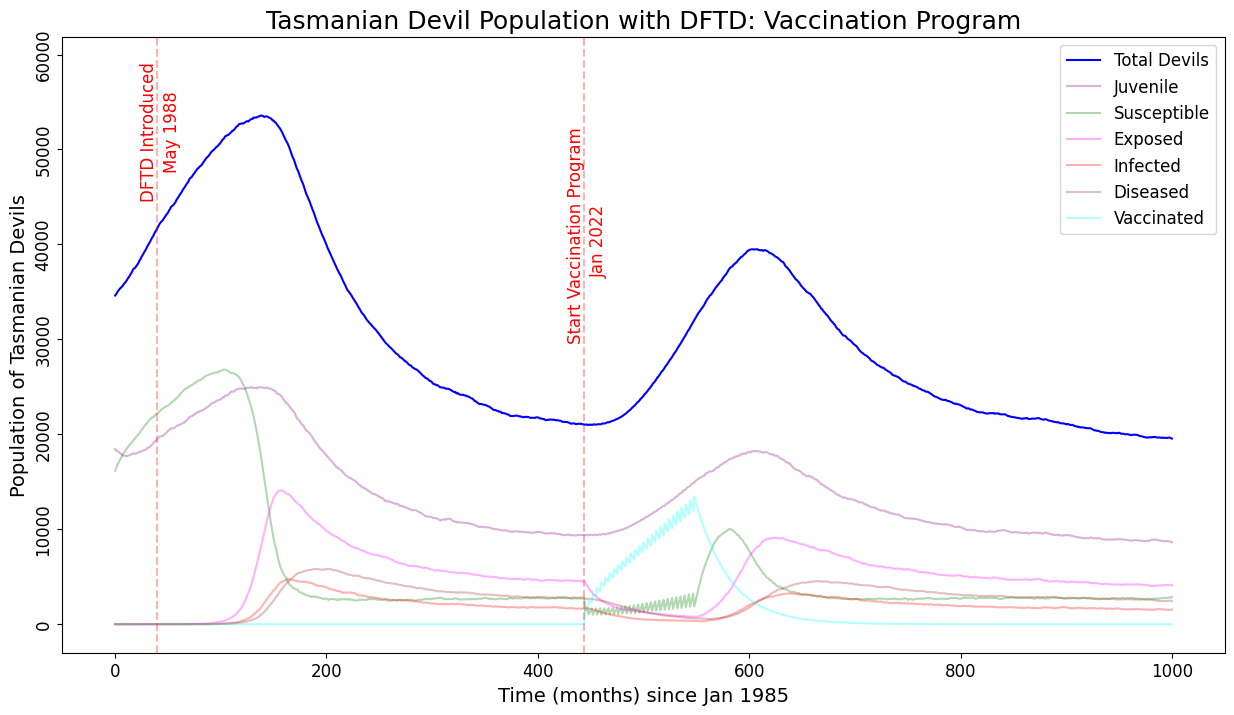

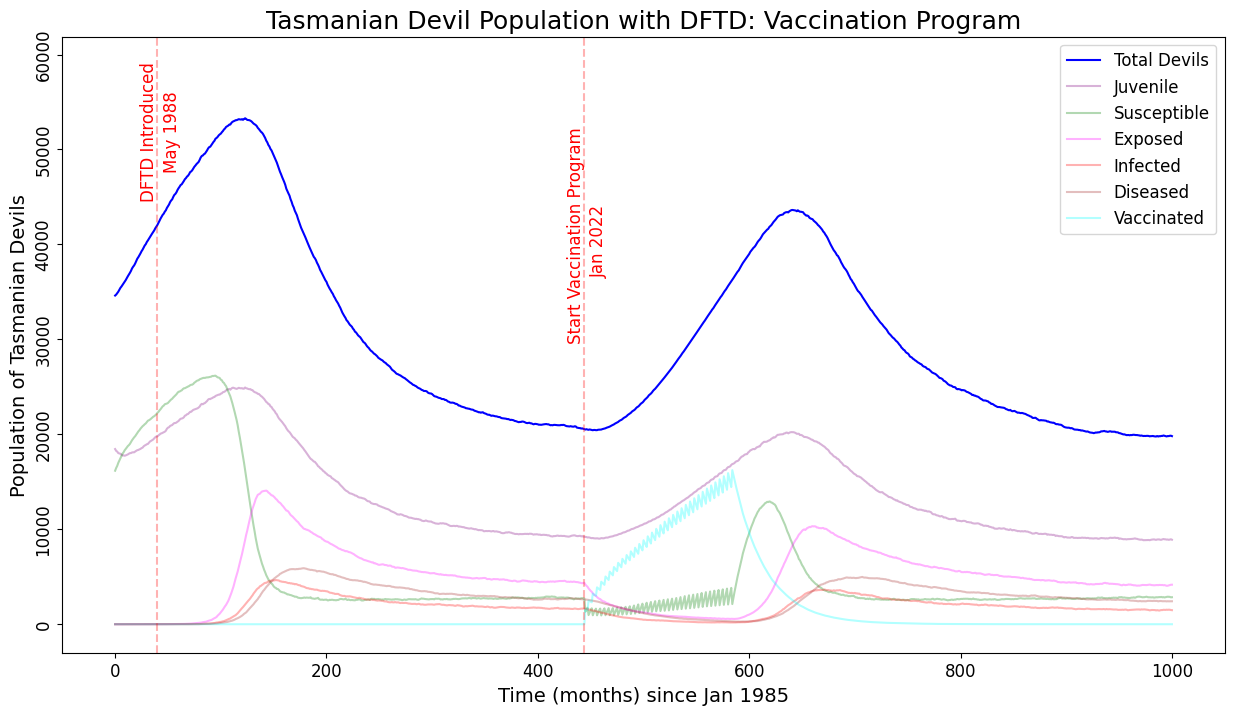

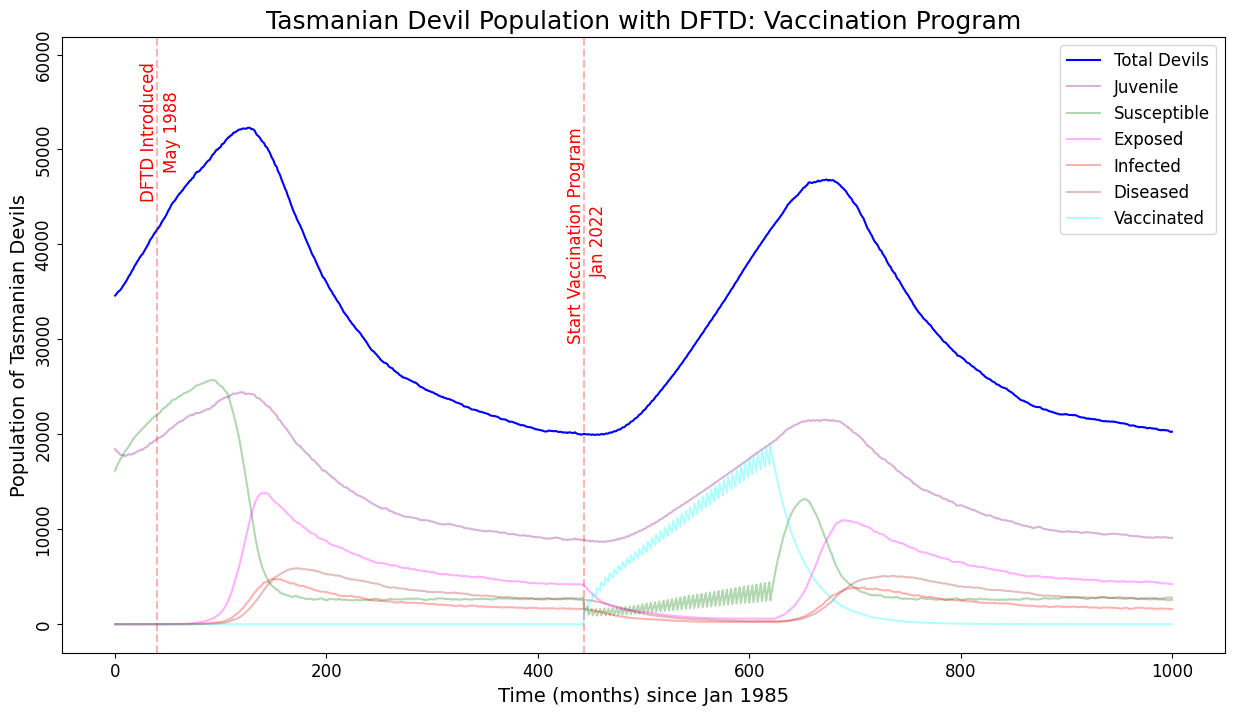

In [15]:
for result in job.results.values():
    plot(result)